In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [29]:
a = np.array([1.1, 2.1, 3.1])
print(np.log(a))

[0.09531018 0.74193734 1.13140211]


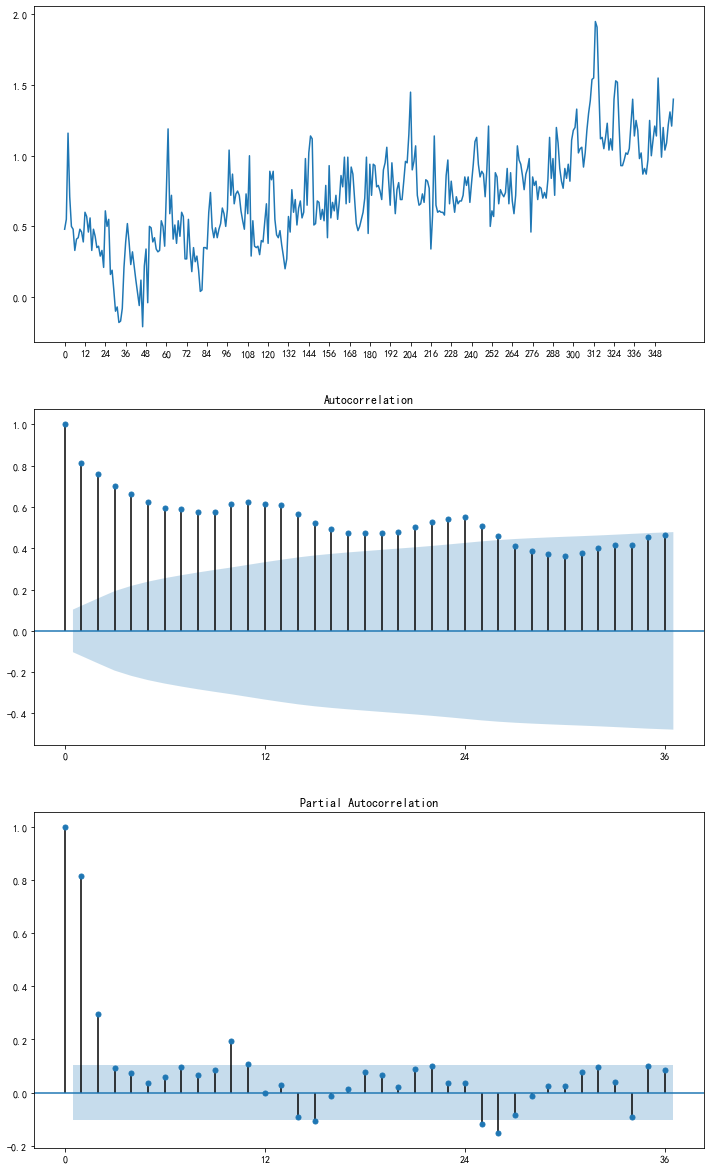

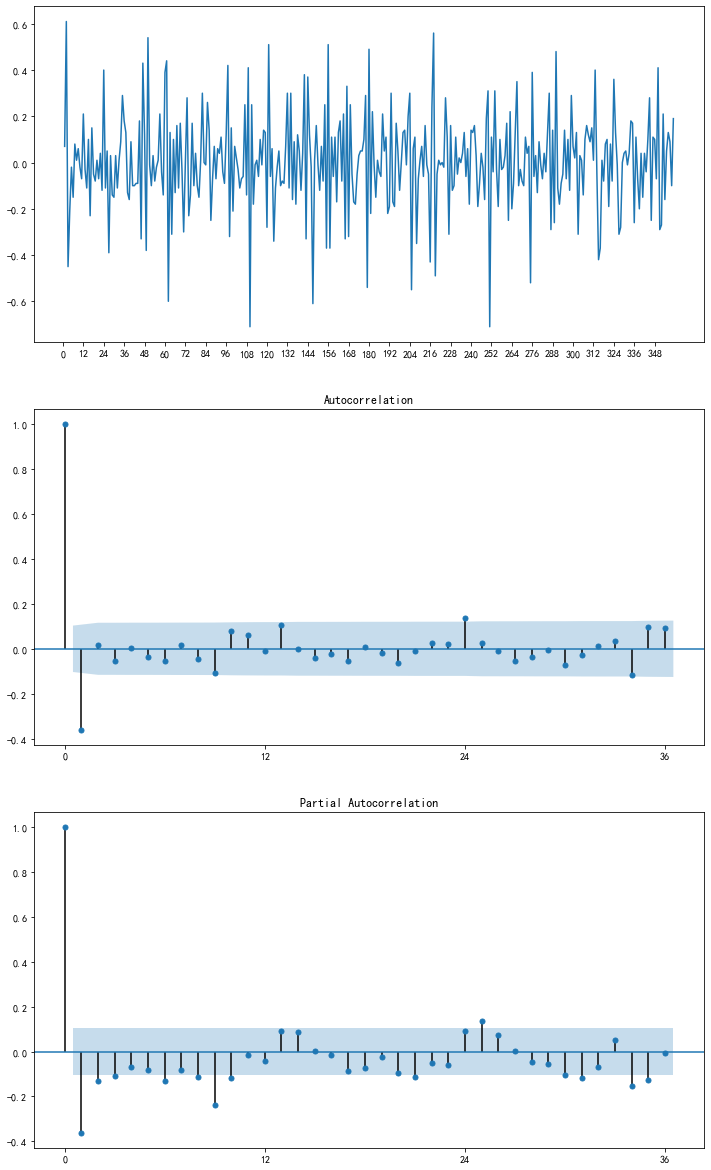

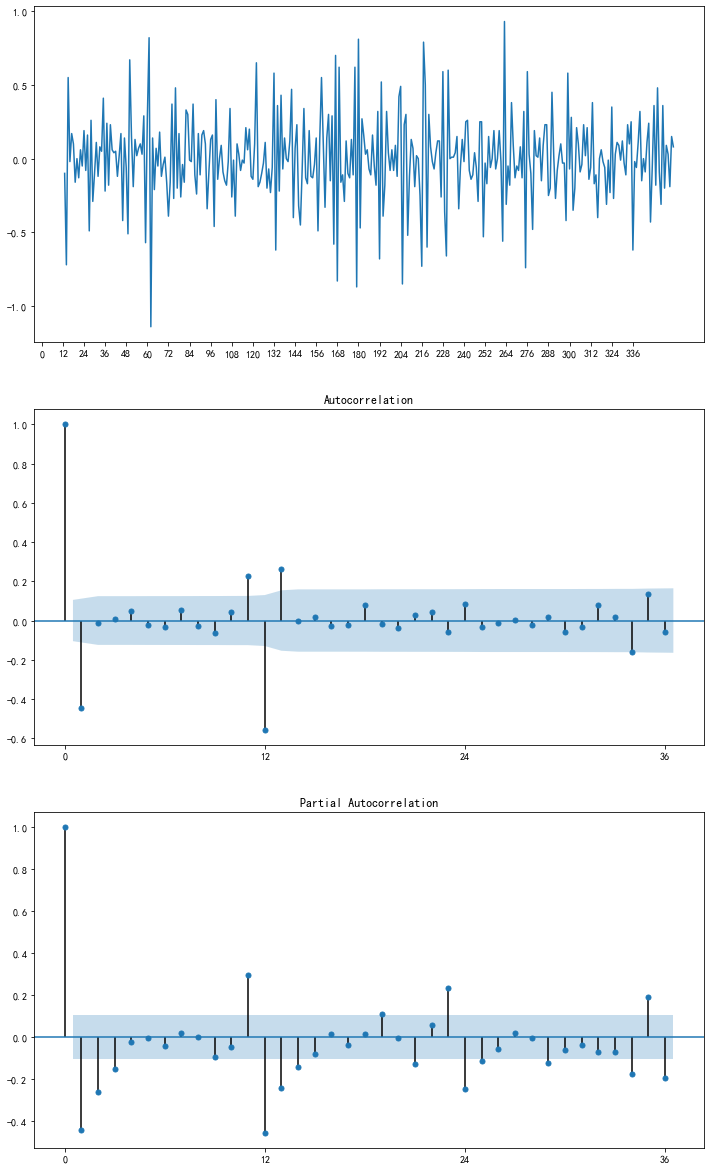

In [3]:
# 海平面数据 2010-2019
path = r"D:\lagua\study\ML\time_series\NH.Ts+dSST.xlsx" # 路径
init_data = pd.read_excel(path, sheet_name='NH.Ts+dSST', header=1, index_col=0).loc[1990:2019, 'Jan':'Dec'] # 读取数据
y = init_data.values.ravel() # 将数据站卡
y = np.asarray(y, dtype=float)
# y = np.log(np.asarray(y, dtype=float))
# print(len(y))
df = pd.DataFrame(y)
# print(df.values.flatten())

# 画出数据的时序图、自相关图和偏自相关图
def myplot(data:pd.DataFrame, i:int):
    # data: pd.DataFrame
    # i: 代表第几个图
    fig, ax = plt.subplots(3, 1, num=i, figsize=(12, 21))
    ax[0].plot(data)
    lags = 2 * int(np.sqrt(len(data)))
    plot_acf(data.values, ax[1], lags=lags)
    plot_pacf(data.values, ax[2], lags=lags).show()
    # plot_acf(data.values, ax[1], 30)
    # plot_pacf(data.values, ax[2], 30).show()
    for i,_ in enumerate(ax):
        if i == 0:
            ax[i].set_xticks(list(range(0, len(data), 12)))
        else:
            ax[i].set_xticks(list(range(0, lags+12, 12)))
        # ax[i].set_xticks(list(range(0,30, 12)))

diff_1 = df.diff(1).dropna() #一阶差分
no_season = diff_1.diff(12).dropna() # 在一阶差分的基础上进行12阶差分
diff_2 = diff_1.diff(1).dropna() # 二阶差分
# 分别画图
myplot(df, 1)
myplot(diff_1, 2)
myplot(no_season, 3)

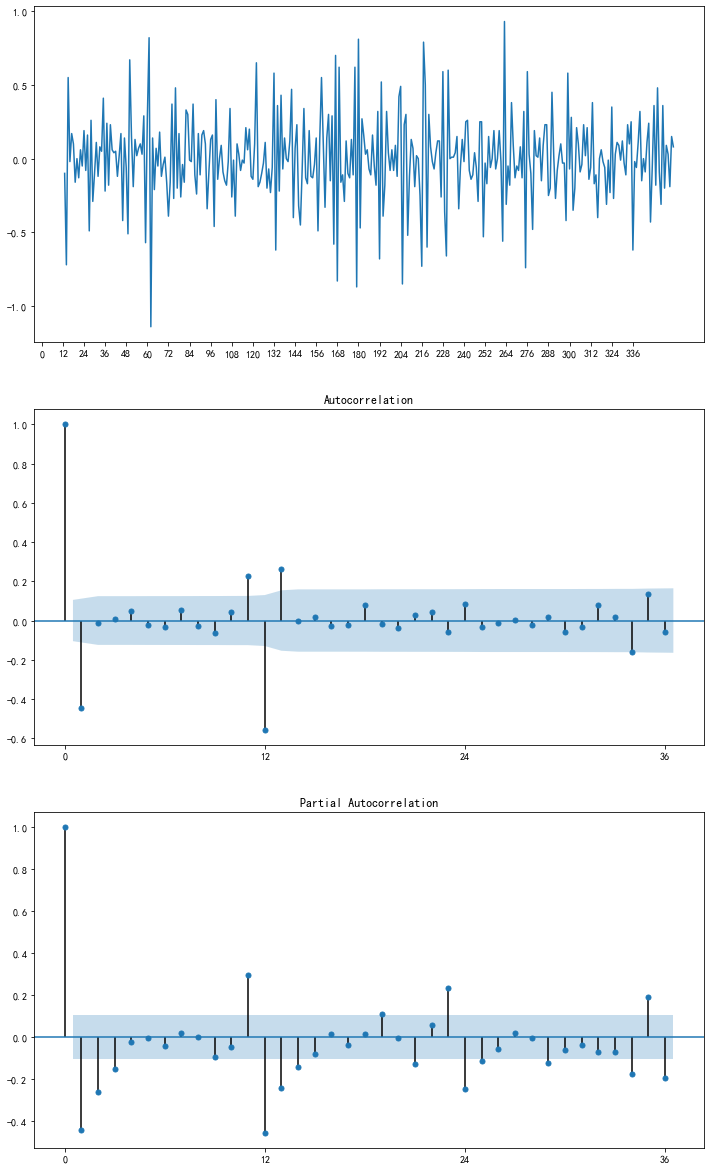

In [4]:
# 比较三种去除趋势项和季节项的方法
# 最后得出结论，使用第一种方法，即使用一阶12步差分最好
# diff_1 = df.diff(1).dropna() #一阶差分
# no_season = diff_1.diff(12).dropna()#在一阶差分的基础上进行12阶差分
# diff_2 = diff_1.diff(1).dropna() # 二阶差分
def eliminate_trend_season(data, method, init_data=init_data):
    """
    method: 
    "pure_diff": 1阶12步差分
    "poly_diff": 多项式拟合，使用12步差分消除季节项
    "min_trend_diff": 最小趋势法去除趋势项与季节项，再在此基础上进行12步差分
    }

    传入的必须是一列数据，之后只需检查是数组，还是DataFrame
    """
    if not isinstance(data, pd.DataFrame):
        # data = np.array(data)
        data = pd.DataFrame(data)
    if method == "pure_diff":
        no_trend = data.diff(1).dropna()
        no_season = no_trend.diff(12).dropna()
        return no_season
    elif method == "poly_diff":
        # 输入的x与y
        x = list(range(len(data)))
        d_val = data.values.flatten()
        # 多项式拟合
        zzz = np.polyfit(x, d_val, 9)
        p4 = np.poly1d(zzz)
        c = p4(x)
        # 减去趋势项（多项式拟合的曲线）
        no_trend = d_val - c
        # 进行12步差分，消除季节项
        if isinstance(no_trend, pd.DataFrame):
            no_season = no_trend.diff(12).dropna()
        else:
            no_trend = pd.DataFrame(no_trend)
            no_season = no_trend.diff(12).dropna()
            # no_season = no_season.diff(12).dropna()
        return no_season
    elif method == "min_trend_diff":
        # TODO: 自动将数据转换成(10, 12)的数据框形式
        m_j = np.mean(init_data, axis=1)
        no_trend = (init_data.T - m_j).T
        no_season_3 = pd.DataFrame(no_trend.values.flatten()).diff(12).dropna()
        return no_season_3
    else:
        raise "please input a true method!!"
no_season = eliminate_trend_season(df, method="pure_diff")
myplot(no_season, 1)
no_season = eliminate_trend_season(df, method="poly_diff")
# myplot(no_season, 2)
# no_season = eliminate_trend_season(df, method="min_trend_diff")
# myplot(no_season, 3)
# myplot()

In [7]:
# 平稳性检验
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.diff(1).dropna().diff(12).dropna())
print(u'一阶12步差分序列的平稳性检验\n', result)

一阶12步差分序列的平稳性检验
 (-9.08927532353749, 3.863646256069488e-15, 14, 332, {'1%': -3.4502011472639724, '5%': -2.8702852297358983, '10%': -2.5714292194077513}, -87.4608194311453)


In [24]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'一阶差分的白噪声检验结果为：\n', acorr_ljungbox(df.diff(1).dropna(), lags=6)) #返回统计量和p值
print(u'一阶差分的白噪声检验结果为：\n', acorr_ljungbox(df.diff(1).dropna(), lags=6)) #返回统计量和p值
print(u'一阶差分的白噪声检验结果为：\n', acorr_ljungbox(df.diff(1).dropna(), lags=6)) #返回统计量和p值

一阶差分的白噪声检验结果为：
 (array([46.99437196, 47.10269673, 48.18590371, 48.19117822, 48.73162784,
       49.86056166]), array([7.11908418e-12, 5.91261178e-11, 1.94406939e-10, 8.61025487e-10,
       2.51795747e-09, 5.01356297e-09]))


In [25]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
print(u'一阶12步序列的白噪声检验结果为：\n', acorr_ljungbox(df.diff(1).dropna().diff(12).dropna(), lags=6)) #返回统计量和p值

一阶12步序列的白噪声检验结果为：
 (array([69.05945861, 69.10660643, 69.12487584, 70.00931964, 70.22520516,
       70.61247787]), array([9.55392347e-17, 9.85578186e-16, 6.57102236e-15, 2.25958202e-14,
       9.19954185e-14, 3.06166120e-13]))


In [17]:
from itertools import product
# ARIMA的参数
ps = range(0, 1)
d = range(0, 2)
qs = range(0, 12)
# 季节项相关的参数
Ps = range(0, 1)
D = range(1, 2)
Qs = range(1, 2)
# 将参数打包，传入下面的数据，是哦那个BIC准则进行参数选择
params_list = list(product(ps, d, qs, Ps, D, Qs))
print(params_list)



[(0, 0, 0, 0, 1, 1), (0, 0, 1, 0, 1, 1), (0, 0, 2, 0, 1, 1), (0, 0, 3, 0, 1, 1), (0, 0, 4, 0, 1, 1), (0, 0, 5, 0, 1, 1), (0, 0, 6, 0, 1, 1), (0, 0, 7, 0, 1, 1), (0, 0, 8, 0, 1, 1), (0, 0, 9, 0, 1, 1), (0, 0, 10, 0, 1, 1), (0, 0, 11, 0, 1, 1), (0, 1, 0, 0, 1, 1), (0, 1, 1, 0, 1, 1), (0, 1, 2, 0, 1, 1), (0, 1, 3, 0, 1, 1), (0, 1, 4, 0, 1, 1), (0, 1, 5, 0, 1, 1), (0, 1, 6, 0, 1, 1), (0, 1, 7, 0, 1, 1), (0, 1, 8, 0, 1, 1), (0, 1, 9, 0, 1, 1), (0, 1, 10, 0, 1, 1), (0, 1, 11, 0, 1, 1)]


In [ ]:
import statsmodels

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm_notebook
from statsmodels.tsa.arima_model import ARIMA
import warnings
# 忽视在模型拟合中遇到的错误
warnings.filterwarnings("ignore")
# 找最优的参数 SARIMAX
def find_best_params(data:np.array, params_list):
    result = []
    best_bic = 100000
    for param in tqdm_notebook(params_list):
        # 模型拟合
        # model = SARIMAX(data,order=(param[0], param[1], param[2]),seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        model = SARIMAX(data, order=(param[0], param[1], param[2]), seasonal_order=(param[3], param[4], param[5], 12)).fit(disp=-1)
        bicc = model.bic # 拟合出模型的BIC值
        # print(bic)
        # 寻找最优的参数
        if bicc < best_bic:
            best_mode = model
            best_bic = bicc
            best_param = param
        param_1 = (param[0], param[1], param[2])
        param_2 = (param[3], param[4], param[5], 12)
        param = 'SARIMA{0}x{1}'.format(param_1, param_2)
        print(param)
        result.append([param, model.bic])

    result_table = pd.DataFrame(result)
    result_table.columns = ['parameters', 'bic']
    result_table = result_table.sort_values(by='bic',ascending=True).reset_index(drop=True)
    return result_table


In [19]:
# data = df.values.flatten()
# df  = df.flatten().astype(float)
# help(SARIMAX)
result_table = find_best_params(df, params_list)
print(result_table)


SARIMA(0, 0, 0)x(0, 1, 1, 12)
SARIMA(0, 0, 1)x(0, 1, 1, 12)
SARIMA(0, 0, 2)x(0, 1, 1, 12)
SARIMA(0, 0, 3)x(0, 1, 1, 12)
SARIMA(0, 0, 4)x(0, 1, 1, 12)
SARIMA(0, 0, 5)x(0, 1, 1, 12)
SARIMA(0, 0, 6)x(0, 1, 1, 12)
SARIMA(0, 0, 7)x(0, 1, 1, 12)
SARIMA(0, 0, 8)x(0, 1, 1, 12)
SARIMA(0, 0, 9)x(0, 1, 1, 12)
SARIMA(0, 0, 10)x(0, 1, 1, 12)
SARIMA(0, 0, 11)x(0, 1, 1, 12)
SARIMA(0, 1, 0)x(0, 1, 1, 12)
SARIMA(0, 1, 1)x(0, 1, 1, 12)
SARIMA(0, 1, 2)x(0, 1, 1, 12)
SARIMA(0, 1, 3)x(0, 1, 1, 12)
SARIMA(0, 1, 4)x(0, 1, 1, 12)
SARIMA(0, 1, 5)x(0, 1, 1, 12)
SARIMA(0, 1, 6)x(0, 1, 1, 12)
SARIMA(0, 1, 7)x(0, 1, 1, 12)
SARIMA(0, 1, 8)x(0, 1, 1, 12)
SARIMA(0, 1, 9)x(0, 1, 1, 12)
SARIMA(0, 1, 10)x(0, 1, 1, 12)
SARIMA(0, 1, 11)x(0, 1, 1, 12)

                        parameters         bic
0    SARIMA(0, 1, 1)x(0, 1, 1, 12) -176.590467
1    SARIMA(0, 1, 2)x(0, 1, 1, 12) -171.113590
2    SARIMA(0, 1, 3)x(0, 1, 1, 12) -167.860805
3    SARIMA(0, 1, 4)x(0, 1, 1, 12) -163.401937
4    SARIMA(0, 1, 5)x(0, 1, 1, 12) -159.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  0   No. Observations:                  360
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  97.069
Date:                            Wed, 30 Dec 2020   AIC                           -188.138
Time:                                    10:49:15   BIC                           -176.590
Sample:                                         0   HQIC                          -183.540
                                            - 360                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5839      0.041    -14.343      0.000      -0.664      -0.504
ma.S.L12      -0.9370      0.037    -24.992      0.000      -1.011      -0.864
sigma2         0.0311      0.002     13.939      0.000       0.027       0.035
===================================================================================
Ljung-Box (Q):                       46.34   Jarque-Bera (JB):                19.19
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.44
Prob(H) (two-sided):                  0.66   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

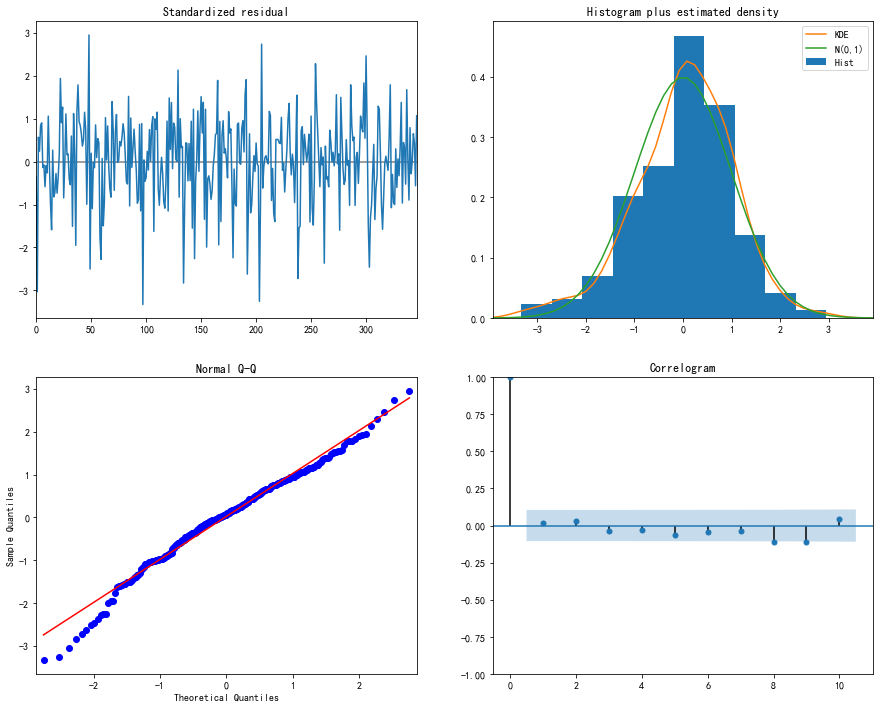

In [28]:
# ma9 = ARIMA(no_season.values, order=(9, 0, 5)).fit(method='css', disp=-1)
# df = df.flatten().astype(float)
ma1 = SARIMAX(df, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(disp=-1)
resid = ma1.resid
# fig, ax = plt.subplots(2, 1, figsize=(16, 16))
# fig, ax = plt.subplots(2, 1, figsize=(16, 16))
# plot_acf(resid.squeeze(), ax[0], lags=120, alpha=0.05)
# plot_pacf(resid, ax[1], lags=200)
# plt.show()

fig = ma1.plot_diagnostics(figsize=(15, 12))
fig.savefig(r'.\test.png')

ma1.summary()
# from statsmodels.api import tsa
# r, q, p = tsa.acf(resid.squeeze(), qstat=True)
# print(len(r), len(q), len(p))
# test_data = np.c_[range(1, len(r)), r[1:], q, p]
# table = pd.DataFrame(test_data, columns=['lag', 'AC', 'Q', 'Prob(>Q)'])
# print(table.set_index('lag'))


In [ ]:
a = list(range(1, 11))
b = pd.date_range(start='2019-12',periods=10, freq='M', closed='left')
print(b)

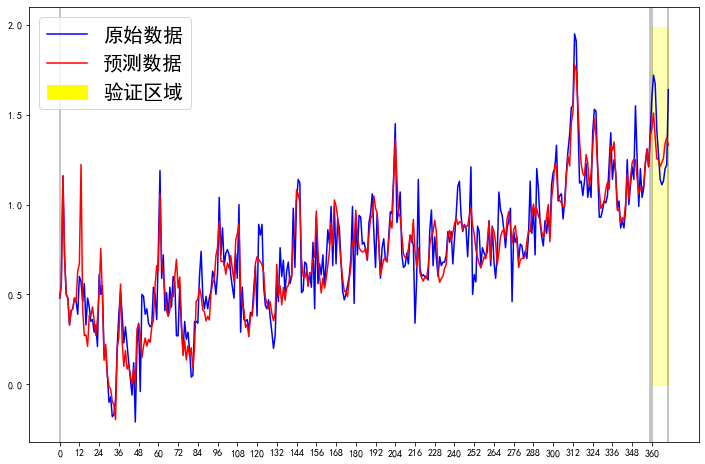

0.032905749669850354 
 0.16258440143847938 
 0.372977053535135


In [40]:
# 预测的第一个数据是0，所以去掉第一个数据
import matplotlib.patches as mpatches

data_predict = ma1.predict(1, 371)
# print(data_predict.shape)
# print(data_predict[-11:])
# print(data_predict[-16:-5])
# print(data_predict[-5:])

init_data = pd.read_excel(path, sheet_name='NH.Ts+dSST', header=1, index_col=0).loc[1990:2020, 'Jan':'Dec']
plt.figure(figsize=(12, 8))
init_x = init_data.values.ravel()[:-1]# 最后一个数据是空的
oral_line, = plt.plot(init_x, color="b", label="原始数据")
# plt.fill_betweenx(np.arange(0.0, 2, 0.01), 120, 130, color='yellow', alpha=0.3)

# axvline_li = [0, 119, 120, 130, 131, 135]
axvline_li = [0, 359, 360, 370]
for i in axvline_li:
    plt.axvline(i, color='k', alpha=0.3)

x = list(range(len(data_predict)))
predict_line, = plt.plot(x, data_predict, color='r', label="预测数据")


plt.fill_betweenx(np.arange(0.0, 2, 0.01), 360, 370, color='yellow', alpha=0.3)
# yellow_patch = mpatches.Patch(color="yellow") 
green_patch = mpatches.Patch(color="green") 
plt.legend(fontsize=20, loc='upper left')
handles=[oral_line, predict_line, yellow_patch, green_patch]
labels=["原始数据", "预测数据", "验证区域"]
plt.legend(handles, labels, fontsize=20, loc='upper left')

plt.xticks(list(range(0, len(data_predict), 12)))
# plt.legend(loc='upper right')
plt.show()

predict_10 = init_x[-11:]
fact_10 = data_predict[-11:]
from sklearn.metrics import mean_squared_error # 均方误差
from sklearn.metrics import mean_absolute_error # 平方绝对误差
from sklearn.metrics import r2_score # R square
mse = mean_squared_error(predict_10, fact_10)
mae = mean_absolute_error(predict_10, fact_10)
r2s = r2_score(predict_10, fact_10)
print(mse, '\n', mae, '\n', r2s)
# ma1.plot_predict(dynamic=False)

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]
 
# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
# 白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(resid, lags=[6, 12], boxpierce=True)

In [ ]:
# 开始定阶数
# 从acf 和 pacf 图可以看出，
# acf截尾， pacf拖尾 => 是MA(13) 即， SARMA(0,1,13, 12)
from statsmodels.tsa.arima_model import ARIMA, SARIMA
# model = ARIMA(no_season.values, order=(0,1,6)) 
# result_arima = model.fit()
# result_arima.summary()
# model = sm.tsa.statespace.SARIMAX()
def optimizeSARIMA(parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table



In [ ]:
# 白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(no_season, boxpierce=True)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA, SARIMA
model = SARIMA(df.values, order=(0,1,12), seasonal=(0, 1, 12, 12)) 
result_arima = model.fit()
result_arima.summary()
# model = sm.tsa.statespace.SARIMAX()

In [ ]:
# 新冠肺炎QUeens 地区的
path_queens = r".\covid192815_updated\US_queens.xlsx"
data_queens = pd.read_excel(path_queens, header=None, names=['month-day', 'confirmed_num'])
data_confirmed = data_queens['confirmed_num']

diff_1 = data_confirmed.diff(1).dropna()
origin_idx = data_queens['month-day'][0]
idx = pd.to_datetime(list(range(len(diff_1))), unit='D',origin=origin_idx)
df = pd.DataFrame(data=diff_1.values, index=idx)

# 将原始累积的数据 --> 一天天的数据，也就是差分
def init_process(data:pd.DataFrame):
    data_pre = data['confirmed_num']
    diff_1 = data_pre.diff(1).dropna()
    origin_idx = data_queens['month-day'][1]
    idx = pd.to_datetime(list(range(len(diff_1))), unit='D',origin=origin_idx)
    df = pd.DataFrame(data=diff_1.values, index=idx, columns=['confirmed_num'])
    return df
df = init_process(data_queens)
# print(df[:10])
plt.figure(figsize=(8, 6))
plt.plot(df)


In [ ]:
# 整个New York省的新冠肺炎数据
path_newyork = r"D:\lagua\study\ML\time_series\covid192815_updated\time_series_covid19_confirmed_US.xlsx"
data_newyork = pd.read_excel(path_newyork, header=None, names=['month-day', 'confirmed_num'], sheet_name='Sheet2')
data_confirmed = data_newyork['confirmed_num']
# data_confirmed = init_process(data_confirmed)
data_confirmed = data_confirmed.diff(1).dropna()

origin_idx = data_newyork['month-day'][1]
idx = pd.to_datetime(list(range(len(data_confirmed))), unit='D',origin=origin_idx)
df = pd.DataFrame(data=diff_1.values, index=idx, columns=['confirmed_num'])

In [ ]:
# print(int(2*len(df.values)/3))
# drop_season = df.diff(int(2*len(df.values)/3)).dropna()
diff_1 = df.diff(1).dropna()
drop_season = diff_1.diff(180).dropna()

diff_2 = diff_1.diff(1).dropna()
diff_3 = diff_2.diff(1).dropna()
# plt.figure(2)
# plt.plot(drop_season)
def dataplot(data, i):
    fig, ax = plt.subplots(3, 1, num=i, figsize=(20, 16))
    ax[0].plot(data, label="init-data")
    plot_acf(data, ax[1], lags=len(data)-1, label="acf")
    plot_pacf(data, ax[2], lags=len(data)-1, label="pacf").show()
# dataplot(df.values, 1)
# dataplot(diff_1, 2)
dataplot(drop_season, 1)
# dataplot(diff_3)
# 一阶差分
# fig, ax = plt.subplots(3, 1, num=1, figsize=(20, 16))
# ax[0].plot(df.values, label="drop_season")
# plot_acf(diff_1, ax[1], lags=len(diff_1)-1, label="drop_season_acf")
# plot_pacf(diff_1, ax[2], lags=len(diff_1)-1, label="drop_season_pacf").show()

# # 二阶差分
# fig, ax = plt.subplots(3, 1, num=2, figsize=(20, 16))
# ax[0].plot(df.values, label="drop_season")
# plot_acf(diff_2, ax[1], lags=len(diff_2)-1, label="drop_season_acf")
# plot_pacf(diff_2, ax[2], lags=len(diff_2)-1, label="drop_season_pacf").show()

In [ ]:
li = list(range(10))

def diff_contain1(li):
    df = pd.DataFrame(li)
    df_shift = df.shift(1, axis=0)
    df = df.diff(1).fillna(df_shift[0])
    # df = df.diff(1).dropna()
    return df
print(diff_contain1(li))
    
    

In [ ]:
path_covid = r".\covid192815\time_series_covid19_confirmed_US_test.csv"
data_covid = pd.read_csv(path_covid, names=['month-day', 'confirmed_num'])
idx = data_covid.values[:, 0]
idx = pd.to_datetime(idx)

confirmed_num = data_covid['confirmed_num'].values
confirmed_num = pd.DataFrame(confirmed_num).diff(1).dropna()

data_diff_1 = confirmed_num.diff(1).dropna()
data_drop_season = data_diff_1.diff(int(len(data_diff_1) / 2)).dropna()
data_diff_2 = data_diff_1.diff(1).dropna()



fig, ax = plt.subplots(2, 1, num=1, figsize=(16, 16))
# ax[0].set_labels(['data_drop_season'])
plot_acf(data_drop_season.values, ax[0], lags=158, label="data_drop_season")
plot_pacf(data_drop_season.values, ax[1], lags=317).show()
fig.legend()
fig, ax = plt.subplots(2, 1, num=2, figsize=(16, 16))
plot_acf(data_diff_1.values, ax[0], lags=318, label="diff_1")
plot_pacf(data_diff_1.values, ax[1], lags=317).show()
fig.legend()



# fig, ax = plt.subplots(2, 1, num=3, figsize=(16, 16))
# plot_acf(data_diff_1.values, ax[0], lags=318)
# # ax[0].set_xticks(range(0, 319, 10))
# ax[0].axvline(x=18,ls="-",c="green")#添加垂直直线
# plot_pacf(data_diff_1.values, ax[1], lags=317).show()
fig, ax = plt.subplots(2, 1, num=3, figsize=(16, 16))
plot_acf(data_diff_2.values, ax[0], lags=316, label="diff_2--auto")
plot_pacf(data_diff_2.values, ax[1], lags=316, label="diff_2--partial").show()
fig.legend()

In [ ]:
print(pd.to_datetime(range(321), unit='D',
               origin=pd.Timestamp('2020-01-28'))[:40])

In [ ]:
print(confirmed_num.index.tolist())

arima_110 = sm.tsa.ARIMA(confirmed_num, (0, 0, 15)).fit()
# print(type(arima_110))

In [ ]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# data_11 = data_covid.values
# def decomposing(timeseries):
#     decomposition = seasonal_decompose(timeseries)
#     trend = decomposition.trend
#     seasonal = decomposition.seasonal
#     residual = decomposition.resid

#     plt.figure(figsize=(16, 12))
#     plt.subplot(411)
#     plt.plot(timeseries, label='Original')
#     plt.legend(loc='best')
#     plt.subplot(412)
#     plt.plot(trend, label='Trend')
#     plt.legend(loc='best')
#     plt.subplot(413)
#     plt.plot(seasonal, label='Seasonarity')
#     plt.legend(loc='best')
#     plt.subplot(414)
#     plt.plot(residual, label='Residual')
#     plt.legend(loc='best')
#     plt.show()

# decomposing(new_df)
# # dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# # purchase_seq_201402_201407 = pd.read_csv('./purchase_seq_201402_201407.csv', parse_dates=['report_date'],
# #                                  index_col='report_date', date_parser=dateparse)
                                

In [ ]:
import turtle
str = input('请输入表白语：')
turtle.speed(10)#画笔速度
turtle.setup(900,350,70,70)
turtle.color('black', 'pink')# 画笔颜色
turtle.pensize(3)   # 画笔粗细
turtle.hideturtle() # 隐藏画笔（先）
turtle.up() # 提笔
turtle.goto(-655, -255) # 移动画笔到指定起始坐标（窗口中心为0,0）
turtle.down()   #下笔
turtle.showturtle() #显示画笔
#画左边的小人
turtle.goto(-600,-200)
turtle.goto(-600,-120)
turtle.circle(35)
turtle.goto(-600,-200)
turtle.forward(40)
turtle.right(90)
turtle.forward(60)
turtle.hideturtle()     
turtle.up()    
turtle.goto(-600, -160)    
turtle.down()  
turtle.showturtle()
turtle.left(90)
turtle.forward(55)
turtle.right(45)
turtle.forward(20)
turtle.hideturtle()    
turtle.up()    
turtle.goto(-600, -145)   
turtle.down()   
turtle.showturtle()
turtle.goto(-545, -145)
turtle.left(90)
turtle.forward(20)

#画第一个爱心
turtle.color('pink', 'pink')
turtle.begin_fill() 
turtle.hideturtle()   
turtle.up()     
turtle.goto(-500, -153)    
turtle.down()   
turtle.showturtle()
turtle.right(90)
turtle.forward(30)
turtle.left(90)
turtle.forward(30)
turtle.left(45)
turtle.circle(10.6,180)
turtle.left(180)
turtle.circle(10.6,180)
turtle.end_fill() 
#下一个大爱心
turtle.color('pink', 'pink')
turtle.begin_fill() 
turtle.hideturtle()    
turtle.up()     
turtle.goto(-430, -143)    
turtle.down()  
turtle.showturtle()
turtle.left(135)
turtle.right(90)
turtle.forward(50)
turtle.left(90)
turtle.forward(50)
turtle.left(45)
turtle.circle(17.67,180)
turtle.left(180)
turtle.circle(17.67,180)
turtle.end_fill() 

#第三个爱心
turtle.color('pink', 'pink')
turtle.begin_fill() 
turtle.hideturtle() 
turtle.up() 
turtle.goto(-315, -133) 
turtle.down()
turtle.showturtle()
turtle.left(135)
turtle.right(90)
turtle.forward(70)
turtle.left(90)
turtle.forward(70)
turtle.left(45)
turtle.circle(24.74,180)
turtle.left(180)
turtle.circle(24.74,180)
turtle.end_fill() 

#第四个爱心
turtle.color('pink', 'pink')
turtle.begin_fill() 
turtle.hideturtle()
turtle.up()
turtle.goto(-187, -133)
turtle.down() 
turtle.showturtle()
turtle.left(135)
turtle.right(90)
turtle.forward(70)
turtle.left(90)
turtle.forward(70)
turtle.left(45)
turtle.circle(24.74,180)
turtle.left(180)
turtle.circle(24.74,180)
turtle.end_fill()

#第5个爱心
turtle.color('pink', 'pink')
turtle.begin_fill() 
turtle.hideturtle()
turtle.up()
turtle.goto(-43.7, -143)
turtle.down()
turtle.showturtle()
turtle.left(135)
turtle.right(90)
turtle.forward(50)
turtle.left(90)
turtle.forward(50)
turtle.left(45)
turtle.circle(17.67,180)
turtle.left(180)
turtle.circle(17.67,180)
turtle.end_fill() 

#第6个爱心
turtle.color('pink', 'pink')
turtle.begin_fill() 
turtle.hideturtle()
turtle.up() 
turtle.goto(53.88, -153)
turtle.down() 
turtle.showturtle()
turtle.right(90)
turtle.right(225)
turtle.forward(30)
turtle.left(90)
turtle.forward(30)
turtle.left(45)
turtle.circle(10.6,180)
turtle.left(180)
turtle.circle(10.6,180)
turtle.end_fill() 

#画右边的小人
turtle.hideturtle()    
turtle.up()
turtle.goto(251.28, -255)  
turtle.down()  
turtle.showturtle()
turtle.goto(196.28,-200)
turtle.goto(196.28,-120)
turtle.left(90)
turtle.circle(35)
turtle.goto(196.28,-200)
turtle.left(180)
turtle.forward(40)
turtle.left(90)
turtle.forward(60)
turtle.hideturtle() 
turtle.up()
turtle.goto(196.28,-160) 
turtle.down()  
turtle.showturtle()  
turtle.right(90)
turtle.forward(55)
turtle.left(45)
turtle.forward(20)
turtle.hideturtle()
turtle.up()   
turtle.goto(196.28, -145) 
turtle.down() 
turtle.showturtle()
turtle.right(45)
turtle.forward(55)
turtle.right(45)
turtle.forward(20)

#画气球线和气球
#第一个气球
turtle.hideturtle() 
turtle.up()  
turtle.goto(-265, -133)   
turtle.down() 
turtle.showturtle()
turtle.goto(-245, 0)
turtle.right(135)
turtle.circle(35)
#第2个气球
turtle.hideturtle()  
turtle.up()   
turtle.goto(-265, -133)  
turtle.down()  
turtle.showturtle()
turtle.goto(-305, 80) 
turtle.circle(40)
#第3个气球
turtle.hideturtle()   
turtle.up()   
turtle.goto(-137, -133) 
turtle.down()   
turtle.showturtle()
turtle.goto(-167, 0)
turtle.circle(35)
#第4一个气球
turtle.hideturtle() 
turtle.up()  
turtle.goto(-137, -133)  
turtle.down() 
turtle.showturtle()
turtle.goto(-117, 80)
turtle.circle(40)
#写字LOVE
turtle.pencolor("GREEN")
turtle.penup()
turtle.goto(-245,10)
turtle.write("O",move=False,align='center',font=("微软雅黑",30,'normal')) 


turtle.pencolor("PURPLE")
turtle.penup()
turtle.goto(-305,90)
turtle.write("L",move=False,align='center',font=("微软雅黑",30,'normal')) 

turtle.pencolor("YELLOW")
turtle.penup()
turtle.goto(-167,10)
turtle.write("V",move=False,align='center',font=("微软雅黑",30,'normal')) 

turtle.pencolor("ORANGE")
turtle.penup()
turtle.goto(-117, 90)
turtle.write("E",move=False,align='center',font=("微软雅黑",30,'normal')) 


#写送给谁
turtle.pencolor("PINK")
turtle.penup()
turtle.goto(300, 200)
turtle.write(str,move=False,align='center',font=("方正舒体",30,'normal'))